# Velocity Classes for Modelling Doppler Broadening in Thermal Systems

- TODO: num vel classes seems wrong, raise bug?
- TODO: Reduce t-steps if possible to make it faster
- TODO: Plot the spectral analysis and mark on the velocity steps.
- TODO: Key will be to show how good the numerical integral is with those steps.

In [1]:
# Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
sns.set_style('darkgrid')

In [2]:
from maxwellbloch import mb_solve

In [3]:
mbs_json = """
{
  "atom": {
    "decays": [
      {
        "channels": [[0, 1]],
        "rate": 1.0
      }
    ],
    "fields": [
      {
        "coupled_levels": [[0, 1]],
        "rabi_freq": 1.0e-3,
        "rabi_freq_t_args": {
          "ampl": 1.0,
          "centre": 0.0,
          "fwhm": 1.0
        },
        "rabi_freq_t_func": "gaussian"
      }
    ],
    "num_states": 2
  },
  "t_min": -2.0,
  "t_max": 10.0,
  "t_steps": 1000,
  "z_min": -0.5,
  "z_max": 1.5,
  "z_steps": 25,
  "velocity_classes": {
    "thermal_delta_min": -5,
    "thermal_delta_max": 5,
    "thermal_delta_steps": 9,
    "thermal_width": 10.0
  },
  "interaction_strengths": [
    1.0
  ],
  "savefile": "velocity-classes"
}
"""

mbs = mb_solve.MBSolve().from_json_str(mbs_json)

In [4]:
mbs.thermal_delta_list/(2*np.pi)

array([-5.        , -3.88888889, -2.77777778, -1.66666667, -0.55555556,
        0.        ,  0.55555556,  1.66666667,  2.77777778,  3.88888889,
        5.        ])

In [5]:
mbs.thermal_weights

array([2.91816829e-06, 1.44035399e-04, 2.68218308e-03, 1.88437733e-02,
       4.99467918e-02, 5.64189584e-02, 4.99467918e-02, 1.88437733e-02,
       2.68218308e-03, 1.44035399e-04, 2.91816829e-06])

In [6]:
Omegas_zt, states_zt = mbs.mbsolve(pbar_chunk_size=2, recalc=True)

 4.0%. Run time:   0.00s. Est. time left: 00:00:00:00
 8.0%. Run time:  29.41s. Est. time left: 00:00:05:38
12.0%. Run time:  58.76s. Est. time left: 00:00:07:10
16.0%. Run time:  89.06s. Est. time left: 00:00:07:47
20.0%. Run time: 118.70s. Est. time left: 00:00:07:54
24.0%. Run time: 148.19s. Est. time left: 00:00:07:49
28.0%. Run time: 177.60s. Est. time left: 00:00:07:36
32.0%. Run time: 207.43s. Est. time left: 00:00:07:20
36.0%. Run time: 237.75s. Est. time left: 00:00:07:02
40.0%. Run time: 267.48s. Est. time left: 00:00:06:41
44.0%. Run time: 297.04s. Est. time left: 00:00:06:18
48.0%. Run time: 326.68s. Est. time left: 00:00:05:53
52.0%. Run time: 356.69s. Est. time left: 00:00:05:29
56.0%. Run time: 386.54s. Est. time left: 00:00:05:03
60.0%. Run time: 416.46s. Est. time left: 00:00:04:37
64.0%. Run time: 446.12s. Est. time left: 00:00:04:10
68.0%. Run time: 475.83s. Est. time left: 00:00:03:43
72.0%. Run time: 505.57s. Est. time left: 00:00:03:16
76.0%. Run time: 534.88s. Es

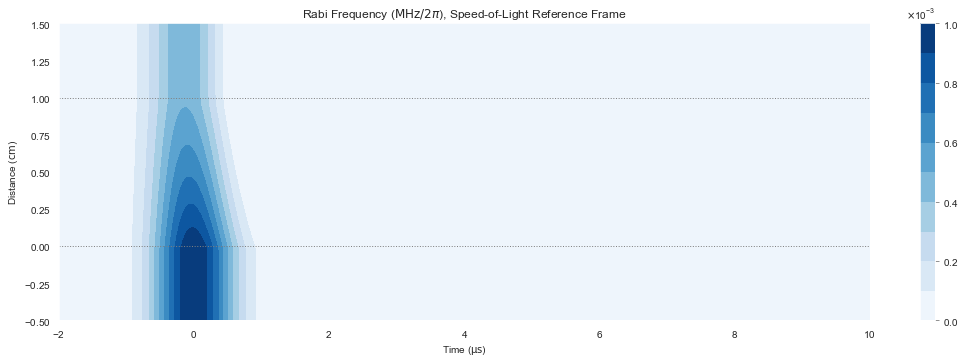

In [7]:
fig, ax = plt.subplots(figsize=(16, 5))
cmap_range = np.linspace(0.0, 1.0e-3, 11)
cf = ax.contourf(mbs.tlist, mbs.zlist, 
                 np.abs(mbs.Omegas_zt[0]/(2*np.pi)), 
                 cmap_range, cmap=plt.cm.Blues)
ax.set_title('Rabi Frequency ($\mathrm{MHz} / 2\pi $), Speed-of-Light Reference Frame')
ax.set_xlabel('Time ($\mathrm{\mu s}$)')
ax.set_ylabel('Distance ($\mathrm{cm}$)')
for y in [0.0, 1.0]:
    ax.axhline(y, c='grey', lw=1.0, ls='dotted')
plt.colorbar(cf);

In [8]:
from maxwellbloch import spectral

In [9]:
mb = mb_solve.maxwell_boltzmann(mbs.thermal_delta_list, 
    mbs.velocity_classes['thermal_width'])

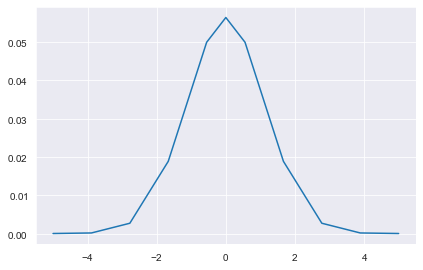

In [10]:
plt.plot(mbs.thermal_delta_list/(2*np.pi), mb)

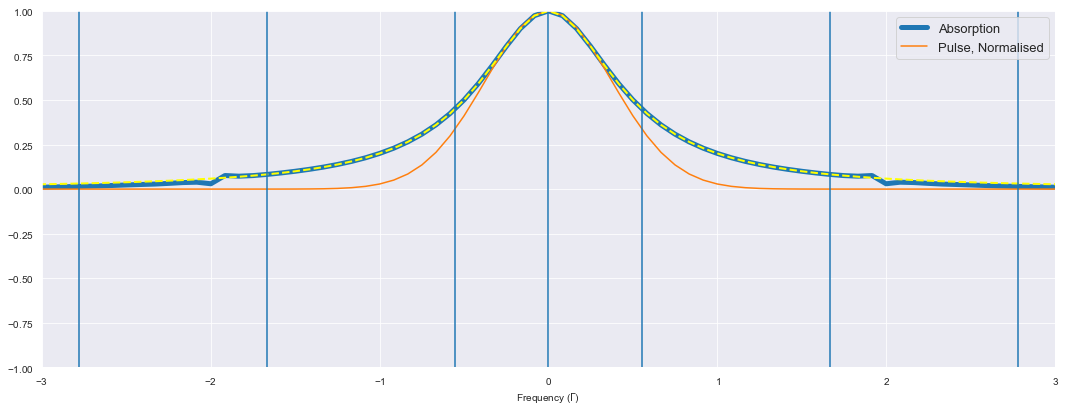

In [12]:
interaction_strength = mbs.interaction_strengths[0]
decay_rate = mbs.atom.decays[0]['rate']
freq_list = spectral.freq_list(mbs)
absorption_linear_known = spectral.absorption_two_linear_known(freq_list, 
    interaction_strength, decay_rate)
dispersion_linear_known = spectral.dispersion_two_linear_known(freq_list, 
    interaction_strength, decay_rate)
rabi_freq_abs_0 = np.abs(spectral.rabi_freq(mbs, 0))[0]

fig = plt.figure(4, figsize=(16, 6))
ax = fig.add_subplot(111)

ax.plot(freq_list, spectral.absorption(mbs, 0, -1), 
        label='Absorption', lw=5.0)
# ax.plot(freq_list, spectral.dispersion(mbs, 0, -1), 
#         label='Dispersion', lw=5.0)

ax.plot(freq_list, 
        rabi_freq_abs_0/np.max(rabi_freq_abs_0),
        label='Pulse, Normalised')

ax.plot(freq_list, absorption_linear_known, ls='dashed', c='yellow', lw=2.0)
# ax.plot(freq_list, dispersion_linear_known, ls='dashed', c='cyan', lw=1.0)

# Plot thermal_delta_list
for d in mbs.thermal_delta_list:
    ax.axvline(d/(2*np.pi))

# ax.scatter(mbs.thermal_delta_list/(2*np.pi), np.zeros(len(mbs.thermal_delta_list)), 
#     marker='o', s=200)

# ax.plot(mbs.thermal_delta_list, mb)

ax.set_xlim(-3.0, 3.0)
ax.set_ylim(-1.0, 1.0)
ax.set_xlabel('Frequency ($\Gamma$)')

ax.legend();

## Using Inner Velocity Steps to Localise a Resonant Peak